# NYC-Taxi Data Analysis


In [15]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, year, month, dayofmonth
import os
import matplotlib.pyplot as plt

#### Data Ingestion ,Preprocessing and Feature Engineering

In this section, we load multiple monthly NYC Yellow Taxi Parquet files, clean the data, convert date fields to timestamps, and engineer new time-based features (e.g., hour, day of week). The resulting DataFrame is cached and registered as a temporary SQL view for reuse in later sections.

In [16]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [17]:
data_dir = "data"
file_prefix = "yellow_tripdata"

file_paths = []

# Add files for 2020–2024 (all months)
for year in range(2020, 2025):
    for month in range(1, 13):
        path = os.path.join(data_dir, f"{file_prefix}_{year}-{str(month).zfill(2)}.parquet")
        if os.path.exists(path):
            file_paths.append(path)

# Add files for 2025 (only Jan–Mar)
for month in range(1, 4):
    path = os.path.join(data_dir, f"{file_prefix}_2025-{str(month).zfill(2)}.parquet")
    if os.path.exists(path):
        file_paths.append(path)


In [18]:
# 🧾 Load multiple monthly Parquet files
if file_paths:
    df = spark.read.parquet(*file_paths)
else:
    print("No valid files found.")

In [19]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double]

In [20]:
# Show schema
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [21]:
# df.show(3)

In [22]:
# Alternative way
pandas_df = df.limit(3).toPandas()
pandas_df.style.set_table_attributes('style="max-height:300px; overflow-y: auto; display:block;"')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-03-01 00:17:16,2025-03-01 00:25:52,1,0.900000,1,N,140,236,1,7.900000,3.500000,0.500000,2.600000,0.000000,1.000000,15.500000,2.500000,0.000000,0.000000
1,1,2025-03-01 00:37:38,2025-03-01 00:43:51,1,0.600000,1,N,140,262,1,6.500000,3.500000,0.500000,2.300000,0.000000,1.000000,13.800000,2.500000,0.000000,0.000000
2,2,2025-03-01 00:24:35,2025-03-01 00:39:49,1,1.940000,1,N,161,68,1,14.900000,1.000000,0.500000,5.160000,0.000000,1.000000,25.810000,2.500000,0.000000,0.750000



#####  Data Type Conversion (datetime fields)
Convert string-type datetime fields (tpep_pickup_datetime, tpep_dropoff_datetime) into timestamp data type, which allows for proper datetime operations (e.g., sorting, filtering by date, calculating durations)

In [23]:
df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
       .withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

##### Counting and Filtering Invalid Entries
Before removing invalid records, we count how many entries have non-positive values or missing timestamps. This helps assess data quality before applying the cleaning logic

In [24]:
# Basic Cleaning: Filter out invalid entries
from pyspark.sql.functions import col

# Define the filter condition for valid rows
valid_condition = (
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("pickup_datetime").isNotNull()) &
    (col("dropoff_datetime").isNotNull())
)

# Count invalid entries (negation of the valid condition)
invalid_count = df.filter(~valid_condition).count()
print(f"Number of invalid entries: {invalid_count}")

# Apply the filter to keep only valid rows
df = df.filter(valid_condition)


Number of invalid entries: 784674


##### Extracting Date and Time Components from pickup_datetime
To enable time-based analysis and modeling, we extract useful temporal features such as hour, day of the week, day of the month, month, and year from the pickup_datetime column

In [25]:
# from pyspark.sql.functions import hour, dayofweek, dayofmonth, month, year

# df = df.withColumn("pickup_hour", hour("pickup_datetime")) \
#        .withColumn("day_of_week", dayofweek("pickup_datetime")) \
#        .withColumn("day", dayofmonth("pickup_datetime")) \
#        .withColumn("month", month("pickup_datetime")) \
#        .withColumn("year", year("pickup_datetime"))

In [26]:
# Show schema and sample data
# df.printSchema()

In [27]:
pandas_df = df.limit(3).toPandas()
pandas_df.style.set_table_attributes('style="max-height:300px; overflow-y: auto; display:block;"')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,pickup_datetime,dropoff_datetime
0,1,2025-03-01 00:17:16,2025-03-01 00:25:52,1,0.900000,1,N,140,236,1,7.900000,3.500000,0.500000,2.600000,0.000000,1.000000,15.500000,2.500000,0.000000,0.000000,2025-03-01 00:17:16,2025-03-01 00:25:52
1,1,2025-03-01 00:37:38,2025-03-01 00:43:51,1,0.600000,1,N,140,262,1,6.500000,3.500000,0.500000,2.300000,0.000000,1.000000,13.800000,2.500000,0.000000,0.000000,2025-03-01 00:37:38,2025-03-01 00:43:51
2,2,2025-03-01 00:24:35,2025-03-01 00:39:49,1,1.940000,1,N,161,68,1,14.900000,1.000000,0.500000,5.160000,0.000000,1.000000,25.810000,2.500000,0.000000,0.750000,2025-03-01 00:24:35,2025-03-01 00:39:49


In [28]:
# Register as Temp View for SQL Queries
df.createOrReplaceTempView("yellow_taxi_trips")

In [29]:
from pyspark.sql.functions import to_timestamp
# Show basic statistics
# print("Summary statistics (trip_distance, fare_amount):")
df.select("trip_distance", "fare_amount").describe().show()

+-------+-----------------+------------------+
|summary|    trip_distance|       fare_amount|
+-------+-----------------+------------------+
|  count|         10413352|          10413352|
|   mean|5.825326975406465| 18.52100415696364|
| stddev|532.6486725379601|271.54243178813044|
|    min|             0.01|              0.01|
|    max|        281085.57|         863372.12|
+-------+-----------------+------------------+



## Section 1: Descriptive Analysis

## Section 2: Geospatial Analysis

This section focuses on spatial trends by identifying high-demand pickup zones. We aggregate pickups by location, merge with NYC taxi zone shapefile data, and create geospatial visualizations showing demand hotspots across the city.

Objective:
- Identify popular pickup zones.

- Visualize demand hotspots in NYC.

- Optionally, export data for map visualization (e.g., with Folium or GeoPandas).



In [33]:
zone_df = spark.read.csv("data/taxi_zone_lookup.csv", header=True, inferSchema=True)

# Join with pickup zone
df = df.join(zone_df, df.PULocationID == zone_df.LocationID, "left") \
       .withColumnRenamed("Borough", "pickup_borough") \
       .withColumnRenamed("Zone", "pickup_zone") \
       .drop("service_zone", "LocationID")


In [34]:
pickup_counts = df.groupBy("pickup_borough", "pickup_zone") \
                  .count() \
                  .orderBy("count", ascending=False)

pickup_counts.show(10, truncate=False)


+--------------+----------------------------+------+
|pickup_borough|pickup_zone                 |count |
+--------------+----------------------------+------+
|Manhattan     |Midtown Center              |487190|
|Manhattan     |Upper East Side South       |473423|
|Manhattan     |Upper East Side North       |437136|
|Queens        |JFK Airport                 |398793|
|Manhattan     |Times Sq/Theatre District   |353394|
|Manhattan     |Penn Station/Madison Sq West|349141|
|Manhattan     |Midtown East                |343886|
|Manhattan     |Lincoln Square East         |316540|
|Manhattan     |Union Sq                    |294043|
|Manhattan     |Murray Hill                 |283852|
+--------------+----------------------------+------+
only showing top 10 rows



In [36]:
pickup_pd = pickup_counts.toPandas()
pickup_pd.to_csv("output/popular_pickup_zones.csv", index=False)


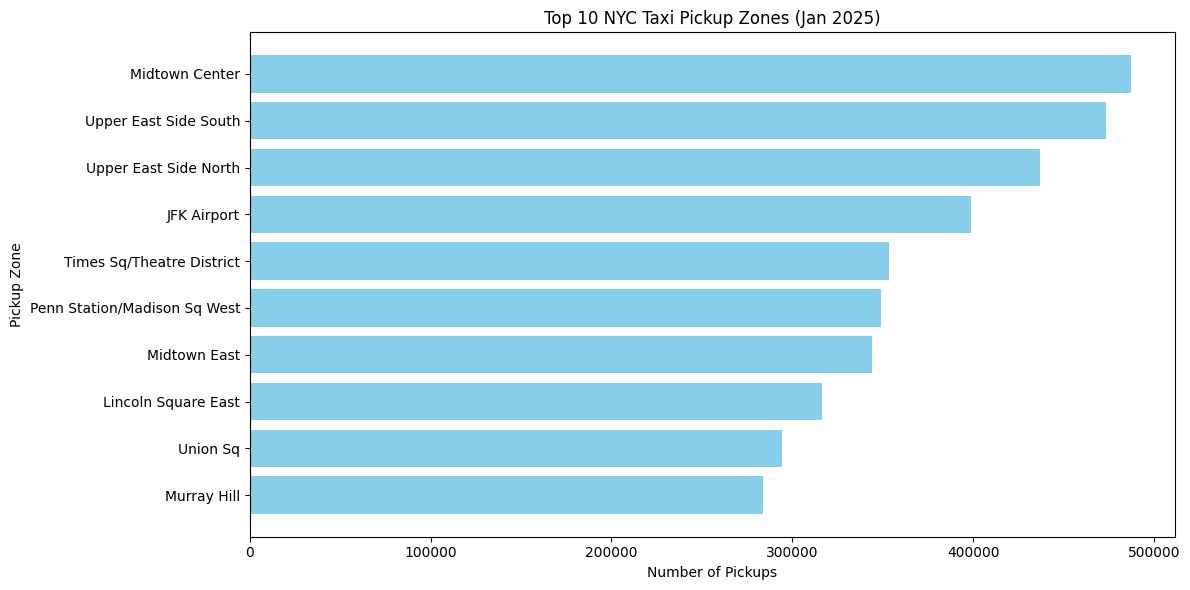

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV you exported from Spark
df2 = pd.read_csv("output/popular_pickup_zones.csv")

# Get top 10 zones
top10 = df2.sort_values(by="count", ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top10["pickup_zone"], top10["count"], color="skyblue")
plt.xlabel("Number of Pickups")
plt.ylabel("Pickup Zone")
plt.title("Top 10 NYC Taxi Pickup Zones (Jan 2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [39]:
!pip install geopandas -q

In [40]:
# Group pickup counts by location
pickup_by_zone = df.groupBy("PULocationID").count()

# Convert to Pandas
pickup_pd = pickup_by_zone.toPandas()


In [47]:
import geopandas as gpd

# Load shapefile
gdf = gpd.read_file("data/taxi_zones/taxi_zones.shp")

# Merge on LocationID
merged = gdf.merge(pickup_pd, left_on="LocationID", right_on="PULocationID")


<Figure size 1200x1000 with 0 Axes>

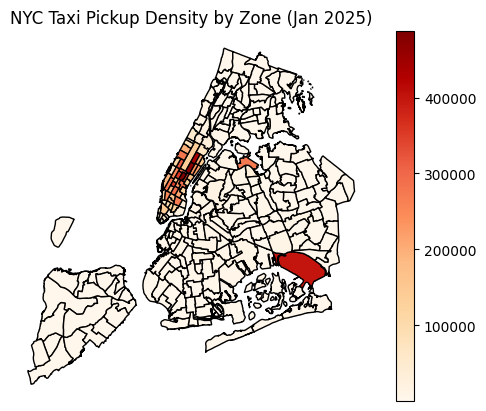

In [48]:
plt.figure(figsize=(12, 10))
merged.plot(column="count", cmap="OrRd", legend=True, edgecolor="black")
plt.title("NYC Taxi Pickup Density by Zone (Jan 2025)")
plt.axis("off")
plt.show()


Drop-off Zone Analysis (Choropleth)

<Figure size 1200x1000 with 0 Axes>

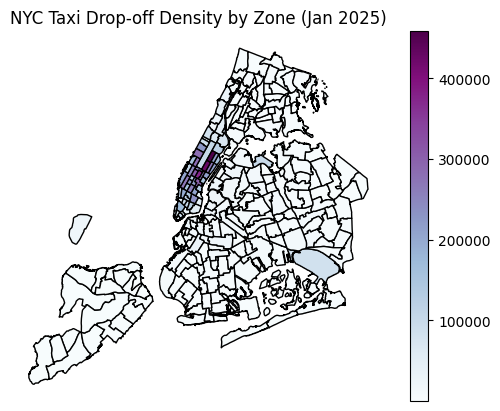

In [49]:
dropoff_by_zone = df.groupBy("DOLocationID").count()
dropoff_pd = dropoff_by_zone.toPandas()

dropoff_merged = gdf.merge(dropoff_pd, left_on="LocationID", right_on="DOLocationID")

plt.figure(figsize=(12, 10))
dropoff_merged.plot(column="count", cmap="BuPu", legend=True, edgecolor="black")
plt.title("NYC Taxi Drop-off Density by Zone (Jan 2025)")
plt.axis("off")
plt.show()


Normalized Pickup Count by Zone Area

<Figure size 1200x1000 with 0 Axes>

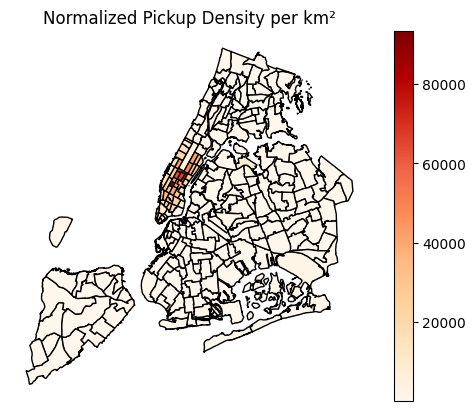

In [50]:
gdf["area_km2"] = gdf.geometry.area / 1e6  # convert m² to km²

pickup_merged = gdf.merge(pickup_pd, left_on="LocationID", right_on="PULocationID")
pickup_merged["count_per_km2"] = pickup_merged["count"] / pickup_merged["area_km2"]

plt.figure(figsize=(12, 10))
pickup_merged.plot(column="count_per_km2", cmap="OrRd", legend=True, edgecolor="black")
plt.title("Normalized Pickup Density per km²")
plt.axis("off")
plt.show()


## Section 3:Revenue and Profitability Analysis

## Section 4: Temporal & Time Series Analysis
We explore trip activity patterns across time. This includes analyzing the distribution of rides by hour, day of the week, and comparing weekday vs. weekend traffic. Visualizations highlight when NYC sees the most taxi activity.

#### 1. Aggregate Trip Volume by Time Intervals (Daily/Monthly/Yearly)

In [ ]:
from pyspark.sql.functions import year

df = df.filter((year(df.pickup_datetime) >= 2015) & (year(df.pickup_datetime) <= 2025))


In [ ]:
df.createOrReplaceTempView("trips")

# Daily trip counts
daily_trips = spark.sql("""
SELECT
    DATE(pickup_datetime) as date,
    COUNT(*) as trip_count
FROM trips
GROUP BY DATE(pickup_datetime)
ORDER BY date
""")


In [ ]:
daily_trips.show()

+----------+----------+
|      date|trip_count|
+----------+----------+
|2024-12-31|        21|
|2025-01-01|     81034|
|2025-01-02|     80673|
|2025-01-03|     87069|
|2025-01-04|     93796|
|2025-01-05|     76128|
|2025-01-06|     76811|
|2025-01-07|     95776|
|2025-01-08|    107181|
|2025-01-09|    111972|
|2025-01-10|    104866|
|2025-01-11|    115787|
|2025-01-12|     96850|
|2025-01-13|     94548|
|2025-01-14|    113936|
|2025-01-15|    118083|
|2025-01-16|    128903|
|2025-01-17|    111522|
|2025-01-18|    112765|
|2025-01-19|    109448|
+----------+----------+
only showing top 20 rows



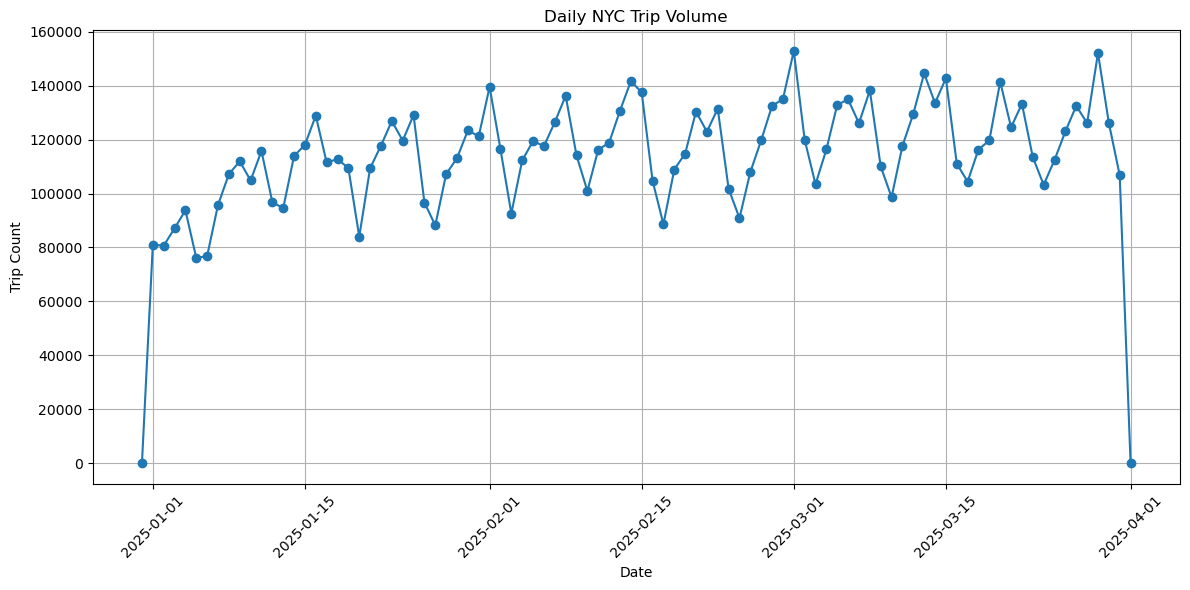

In [ ]:
daily_pd = daily_trips.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_pd['date'], daily_pd['trip_count'], marker='o')
plt.title("Daily NYC Trip Volume")
plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
monthly_trips = spark.sql("""
SELECT
    YEAR(pickup_datetime) AS year,
    MONTH(pickup_datetime) AS month,
    COUNT(*) AS trip_count
FROM trips
GROUP BY YEAR(pickup_datetime), MONTH(pickup_datetime)
ORDER BY year, month
""")

In [ ]:
monthly_trips.show()

+----+-----+----------+
|year|month|trip_count|
+----+-----+----------+
|2024|   12|        21|
|2025|    1|   3253872|
|2025|    2|   3310812|
|2025|    3|   3848643|
|2025|    4|         2|
+----+-----+----------+



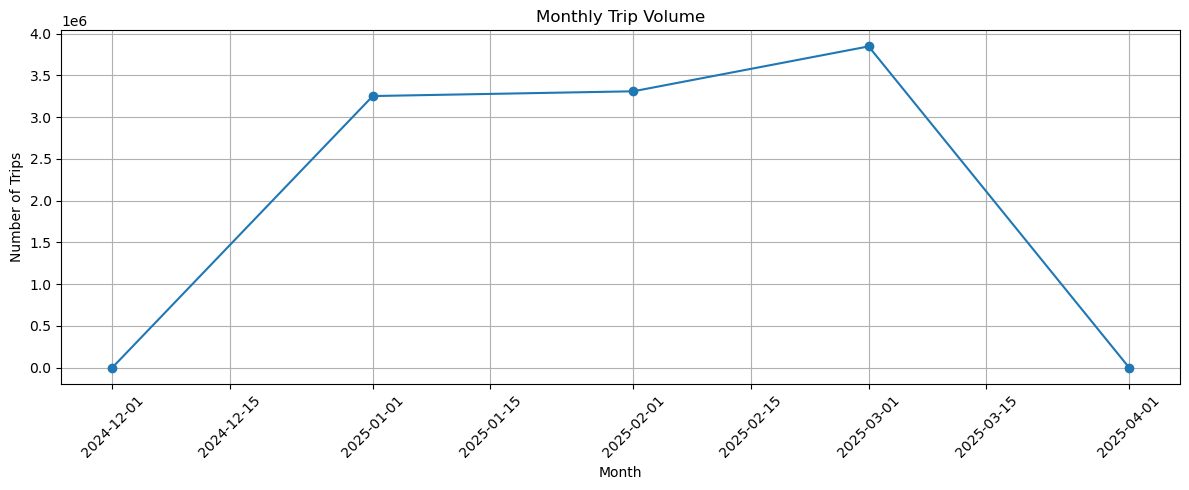

In [ ]:
monthly_pd = monthly_trips.toPandas()
monthly_pd['month_start'] = pd.to_datetime(monthly_pd[['year', 'month']].assign(day=1))
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(monthly_pd['month_start'], monthly_pd['trip_count'], marker='o', linestyle='-')
plt.title("Monthly Trip Volume")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
yearly_trips = spark.sql("""
SELECT
    YEAR(pickup_datetime) AS year,
    COUNT(*) AS trip_count
FROM trips
GROUP BY YEAR(pickup_datetime)
ORDER BY year
""")


In [ ]:
yearly_trips.show()

+----+----------+
|year|trip_count|
+----+----------+
|2024|        21|
|2025|  10413329|
+----+----------+



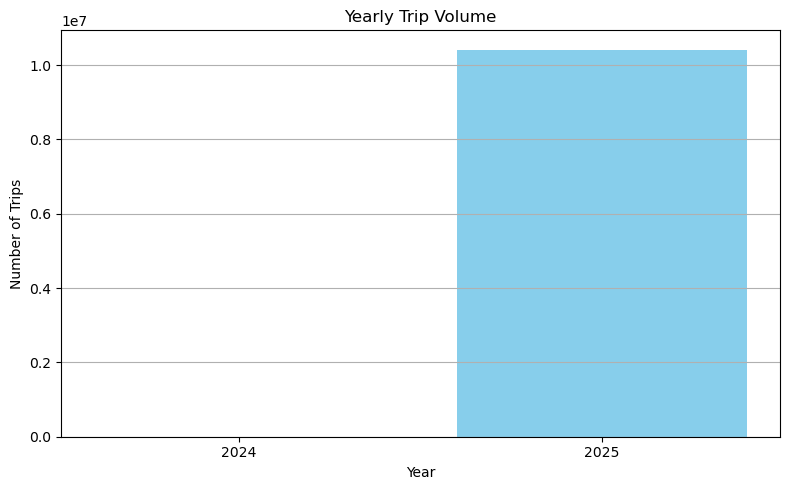

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8, 5))
plt.bar(yearly_pd['year'], yearly_pd['trip_count'], color='skyblue')
plt.title("Yearly Trip Volume")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.grid(axis='y')

# Ensure x-axis only shows whole numbers
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


#### 2. Study Patterns by Hour / Day of Week / Month

In [ ]:
# Required libraries
from pyspark.sql.functions import hour, dayofweek, date_format, col
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df.createOrReplaceTempView("trips")

trips_by_hour = spark.sql("""
    SELECT hour(pickup_datetime) AS hour, COUNT(*) AS trip_count
    FROM trips
    GROUP BY hour
    ORDER BY hour
""")


In [ ]:
trips_by_hour.show()

+----+----------+
|hour|trip_count|
+----+----------+
|   0|    311164|
|   1|    206909|
|   2|    132981|
|   3|     92489|
|   4|     69148|
|   5|     73104|
|   6|    150501|
|   7|    297792|
|   8|    413979|
|   9|    431140|
|  10|    444901|
|  11|    476174|
|  12|    519326|
|  13|    547769|
|  14|    588190|
|  15|    617834|
|  16|    617309|
|  17|    697098|
|  18|    741060|
|  19|    661526|
+----+----------+
only showing top 20 rows



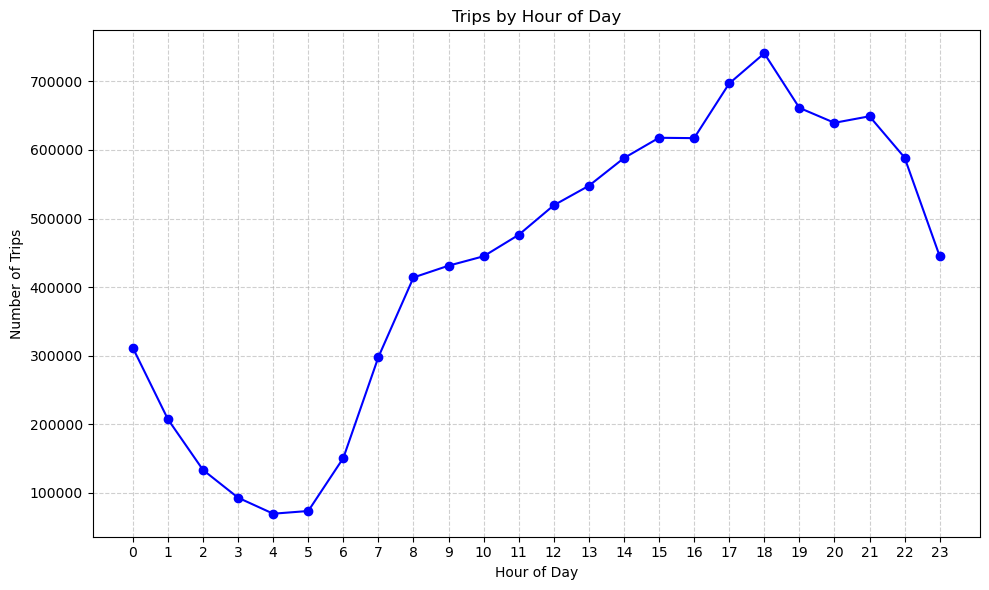

In [ ]:
import matplotlib.pyplot as plt
pdf = trips_by_hour.toPandas()

# Make sure data is sorted by hour
pdf = pdf.sort_values("hour")

plt.figure(figsize=(10, 6))
plt.plot(pdf["hour"], pdf["trip_count"], marker='o', linestyle='-', color='blue')

plt.title("Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
trips_by_dow = spark.sql("""
    SELECT dayofweek(pickup_datetime) AS day_of_week, COUNT(*) AS trip_count
    FROM trips
    GROUP BY day_of_week
    ORDER BY day_of_week
""")

trips_by_dow.show()

+-----------+----------+
|day_of_week|trip_count|
+-----------+----------+
|          1|   1397150|
|          2|   1233198|
|          3|   1334567|
|          4|   1515390|
|          5|   1636560|
|          6|   1580777|
|          7|   1715708|
+-----------+----------+



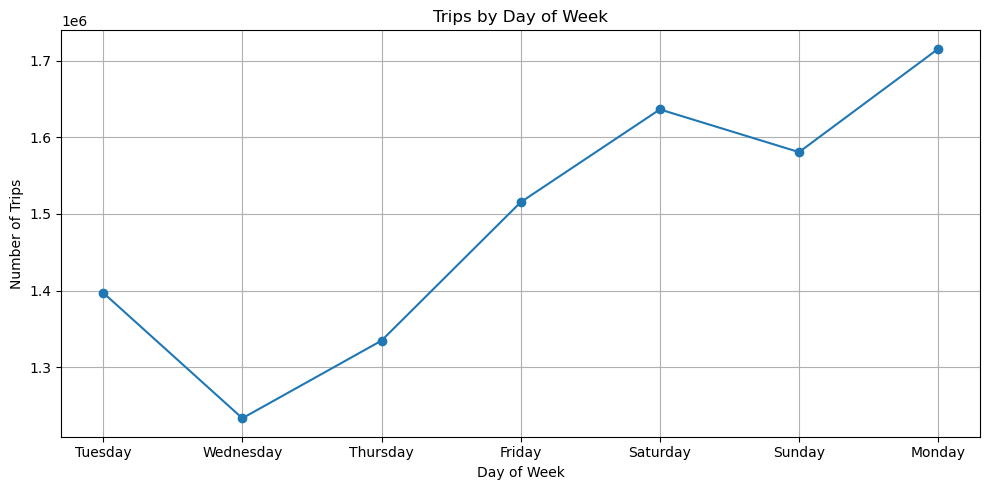

In [ ]:
pdf_dow = trips_by_dow.toPandas().sort_values("day_of_week")

# Optional: Replace numbers with day names (1 = Sunday, 7 = Saturday)
import calendar
pdf_dow["day_name"] = pdf_dow["day_of_week"].apply(lambda x: calendar.day_name[(x % 7)])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf_dow["day_name"], pdf_dow["trip_count"], marker='o')
plt.title("Trips by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()

+-----+----------+
|month|trip_count|
+-----+----------+
|    1|   3253872|
|    2|   3310812|
|    3|   3848643|
|    4|         2|
|   12|        21|
+-----+----------+



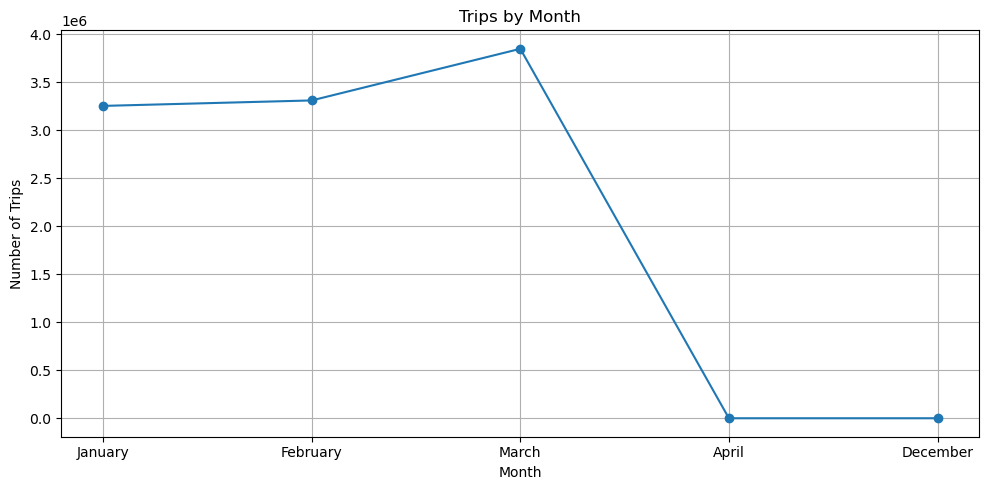

In [ ]:
trips_by_month = spark.sql("""
    SELECT month(pickup_datetime) AS month, COUNT(*) AS trip_count
    FROM trips
    GROUP BY month
    ORDER BY month
""")
trips_by_month.show()

pdf_month = trips_by_month.toPandas().sort_values("month")

# Optional: Month name mapping
pdf_month["month_name"] = pdf_month["month"].apply(lambda x: calendar.month_name[x])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf_month["month_name"], pdf_month["trip_count"], marker='o')
plt.title("Trips by Month")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. Decompose Time Series (Trend, Seasonality)

In [ ]:
pdf_daily = daily_trips.toPandas().sort_values("date")
pdf_daily["date"] = pd.to_datetime(pdf_daily["date"])
pdf_daily.set_index("date", inplace=True)


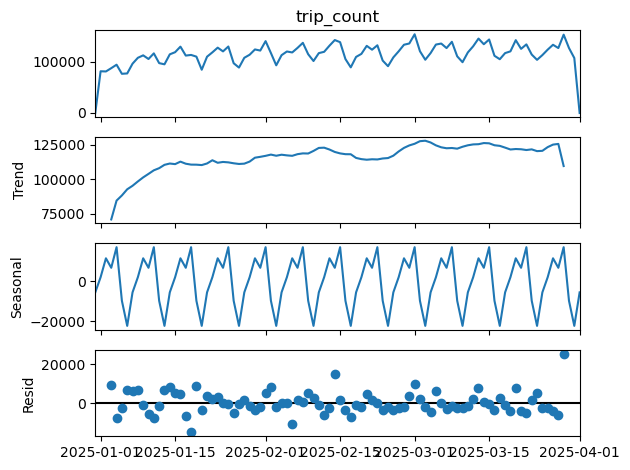

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure data is regularly spaced (daily), or reindex with missing days filled if needed
# You can interpolate or fill missing dates if necessary

# Decompose (model='additive' or 'multiplicative')
result = seasonal_decompose(pdf_daily["trip_count"], model='additive', period=7)  # weekly seasonality

# Plot
result.plot()
plt.tight_layout()
plt.show()


In [ ]:
# pdf_monthly = monthly_trips.toPandas().sort_values("month")

# # Convert month to datetime and set index
# pdf_monthly["month"] = pd.to_datetime(pdf_monthly["month"])
# pdf_monthly.set_index("month", inplace=True)
# pdf_monthly = pdf_monthly.asfreq('MS')  # MS = Month Start


In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt

# # Perform decomposition with yearly seasonality (period=12)
# result = seasonal_decompose(pdf_monthly["trip_count"], model='additive', period=12)

# # Plot the decomposed components
# result.plot()
# plt.tight_layout()
# plt.show()


#### Rolling Average of Daily Trips or Revenue

In [ ]:
# from pyspark.sql.window import Window
# from pyspark.sql.functions import avg

# # Define a window of previous 6 days + current day = 7-day rolling average
# window_spec = Window.orderBy("trip_date").rowsBetween(-6, 0)

# df_rolling = daily_trips.withColumn("rolling_avg_7d", avg("trip_count").over(window_spec))

# df_rolling.show()


In [ ]:
pdf["rolling_avg_7d"] = pdf["trip_count"].rolling(window=7).mean()


#### 6. Time-Based Clustering (e.g., Peak vs. Off-Peak)


In [ ]:
from pyspark.sql.functions import col, hour, when

# Step 1: Extract hour from pickup_datetime
df = df.withColumn("hour", hour(col("pickup_datetime")))

# Step 2: Create time_segment based on hour
df = df.withColumn("time_segment",
    when((col("hour") >= 7) & (col("hour") <= 9), "morning_peak")
    .when((col("hour") >= 17) & (col("hour") <= 19), "evening_peak")
    .otherwise("off_peak")
)


In [ ]:
trips_by_segment = df.groupBy("time_segment").count().orderBy("time_segment")
trips_by_segment.show()


+------------+-------+
|time_segment|  count|
+------------+-------+
|evening_peak|2099684|
|morning_peak|1142911|
|    off_peak|7170755|
+------------+-------+



In [ ]:
pdf = trips_by_segment.toPandas()

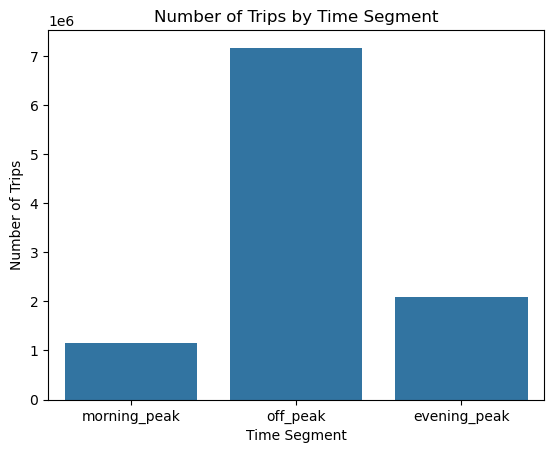

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=pdf, x="time_segment", y="count", order=["morning_peak", "off_peak", "evening_peak"])
plt.title("Number of Trips by Time Segment")
plt.xlabel("Time Segment")
plt.ylabel("Number of Trips")
plt.show()


#### 7. Build Models to Forecast Demand (ARIMA, Prophet)


In [ ]:
!pip install prophet

20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\asus\AppData\Local\Temp\ipykernel_14328\1954682659.py:14: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



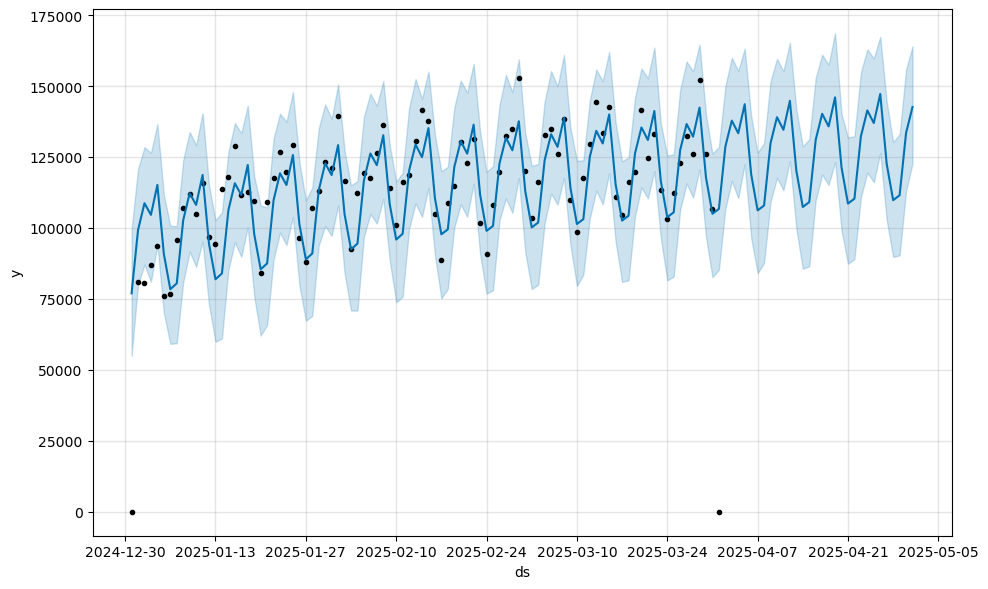

In [ ]:
from prophet import Prophet

pdf = daily_trips.toPandas()
pdf = pdf.rename(columns={"date": "ds", "trip_count": "y"})

model = Prophet()
model.fit(pdf)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Only main forecast plot
fig = model.plot(forecast)
fig.show()


## Section 5: Trip Fare Prediction